In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [7]:
# Reading the data
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()


,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


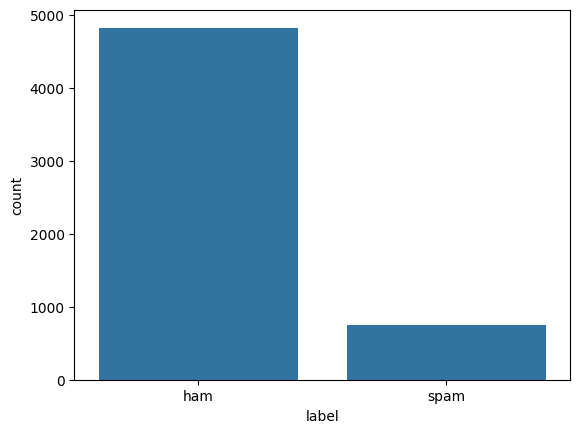

In [9]:
sns.countplot(x=df['label'])
plt.show()


In [10]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)


15


In [11]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
	  s.add(word)
total_words_length=len(s)
print(total_words_length)


15585


In [12]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
	new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

In [13]:
#Building the models

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)


MultinomialNB()

In [15]:
nb_accuracy=accuracy_score(y_test,baseline_model.predict(X_test_vec))

print(nb_accuracy)

print(classification_report(y_test, baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [20]:
#Model 1: Creating custom Text vectorization and embedding layers:

In [21]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
	max_tokens=MAXTOKENS,
	standardize='lower_and_strip_punctuation',
	output_mode='int',
	output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)


In [22]:
embedding_layer = layers.Embedding(
	input_dim=MAXTOKENS,
	output_dim=128,
	embeddings_initializer='uniform',
	input_length=OUTPUTLEN
)


In [23]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
	label_smoothing=0.5), metrics=['accuracy'])


In [24]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [25]:
history_1 = model_1.fit(X_train, y_train, epochs=5,validation_data=(X_test,y_test), validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 8s 48ms/step - loss: 0.6028 - accuracy: 0.9204 - val_loss: 0.5765 - val_accuracy: 0.9740
Epoch 2/5
140/140 [==============================] - 5s 33ms/step - loss: 0.5701 - accuracy: 0.9881 - val_loss: 0.5731 - val_accuracy: 0.9821
Epoch 3/5
140/140 [==============================] - 4s 30ms/step - loss: 0.5658 - accuracy: 0.9955 - val_loss: 0.5726 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 5s 36ms/step - loss: 0.5642 - accuracy: 0.9980 - val_loss: 0.5725 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 4s 32ms/step - loss: 0.5635 - accuracy: 0.9989 - val_loss: 0.5727 - val_accuracy: 0.9821


<Axes: >

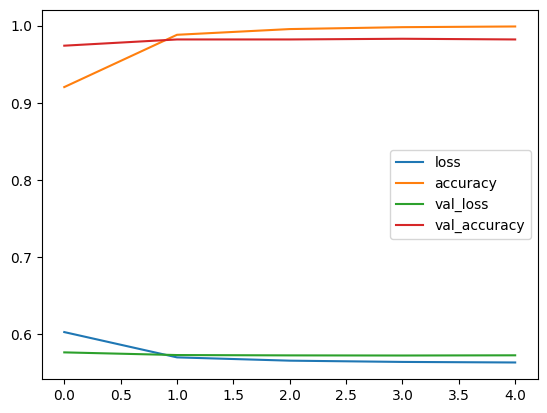

In [26]:
pd.DataFrame(history_1.history).plot()

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
	'''
	simply compile the model with adam optimzer
	'''
	model.compile(optimizer=keras.optimizers.Adam(),
				loss=keras.losses.BinaryCrossentropy(),
				metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
			X_test=X_test, y_test=y_test):
	'''
	fit the model with given epochs, train
	and test data
	'''
	history = model.fit(X_train,
						y_train,
						epochs=epochs,
						validation_data=(X_test, y_test),
						validation_steps=int(0.2*len(X_test)))
	return history

def evaluate_model(model, X, y):
	'''
	evaluate the model and returns accuracy,
	precision, recall and f1-score
	'''
	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict


In [28]:
#Model -2 Bidirectional LSTM

In [29]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
	64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model


Epoch 1/5
140/140 [==============================] - 25s 105ms/step - loss: 0.0611 - accuracy: 0.9816 - val_loss: 0.0790 - val_accuracy: 0.9839
Epoch 2/5
140/140 [==============================] - 12s 85ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.0976 - val_accuracy: 0.9794
Epoch 3/5
140/140 [==============================] - 13s 94ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0890 - val_accuracy: 0.9785
Epoch 4/5
140/140 [==============================] - 13s 94ms/step - loss: 4.9774e-04 - accuracy: 1.0000 - val_loss: 0.1013 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 14s 101ms/step - loss: 6.2124e-05 - accuracy: 1.0000 - val_loss: 0.1235 - val_accuracy: 0.9803


In [30]:
compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model

Epoch 1/5
140/140 [==============================] - 24s 111ms/step - loss: 1.1841e-06 - accuracy: 1.0000 - val_loss: 0.2248 - val_accuracy: 0.9812
Epoch 2/5
140/140 [==============================] - 12s 86ms/step - loss: 5.7975e-08 - accuracy: 1.0000 - val_loss: 0.2329 - val_accuracy: 0.9812
Epoch 3/5
140/140 [==============================] - 25s 182ms/step - loss: 2.8331e-08 - accuracy: 1.0000 - val_loss: 0.2404 - val_accuracy: 0.9812
Epoch 4/5
140/140 [==============================] - 20s 142ms/step - loss: 1.8057e-08 - accuracy: 1.0000 - val_loss: 0.2458 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 13s 95ms/step - loss: 1.3332e-08 - accuracy: 1.0000 - val_loss: 0.2503 - val_accuracy: 0.9812


In [32]:
#Model -3 Transfer Learning with USE Encoder

In [33]:
import tensorflow_hub as hub

# model with Sequential api
model_3 = keras.Sequential()

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
						trainable=False,
						input_shape=[],
						dtype=tf.string,
						name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)


Epoch 1/5
140/140 [==============================] - 8s 34ms/step - loss: 0.2668 - accuracy: 0.9230 - val_loss: 0.1064 - val_accuracy: 0.9704
Epoch 2/5
140/140 [==============================] - 6s 40ms/step - loss: 0.0760 - accuracy: 0.9791 - val_loss: 0.0697 - val_accuracy: 0.9758
Epoch 3/5
140/140 [==============================] - 4s 26ms/step - loss: 0.0534 - accuracy: 0.9854 - val_loss: 0.0593 - val_accuracy: 0.9794
Epoch 4/5
140/140 [==============================] - 5s 34ms/step - loss: 0.0465 - accuracy: 0.9856 - val_loss: 0.0536 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0402 - accuracy: 0.9883 - val_loss: 0.0519 - val_accuracy: 0.9821


In [34]:
compile_model(model_3)
history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 8s 41ms/step - loss: 0.0353 - accuracy: 0.9872 - val_loss: 0.0512 - val_accuracy: 0.9839
Epoch 2/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0328 - accuracy: 0.9899 - val_loss: 0.0503 - val_accuracy: 0.9848
Epoch 3/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0299 - accuracy: 0.9906 - val_loss: 0.0504 - val_accuracy: 0.9857
Epoch 4/5
140/140 [==============================] - 4s 30ms/step - loss: 0.0274 - accuracy: 0.9906 - val_loss: 0.0517 - val_accuracy: 0.9839
Epoch 5/5
140/140 [==============================] - 3s 21ms/step - loss: 0.0246 - accuracy: 0.9924 - val_loss: 0.0520 - val_accuracy: 0.9865


In [35]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
							'Custom-Vec-Embedding Model':model_1_results,
							'Bidirectional-LSTM Model':model_2_results,
							'USE-Transfer learning Model':model_3_results}).transpose()

total_results


35/35 [==============================] - 1s 11ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.979372,0.970370,0.873333,0.919298
Bidirectional-LSTM Model,0.981166,0.970803,0.886667,0.926829
USE-Transfer learning Model,0.986547,0.972028,0.926667,0.948805


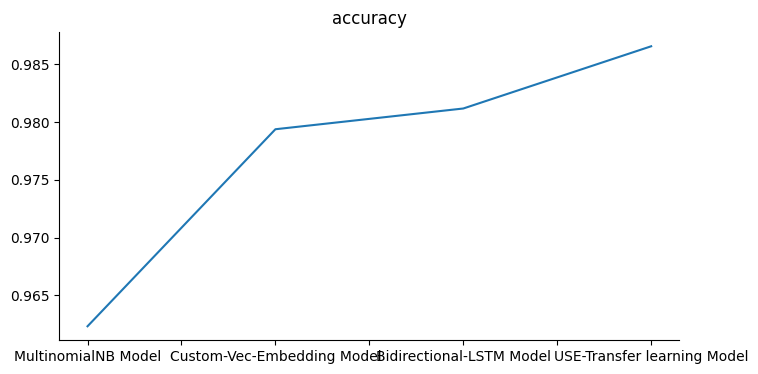

In [37]:
# @title accuracy

from matplotlib import pyplot as plt
total_results['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: >

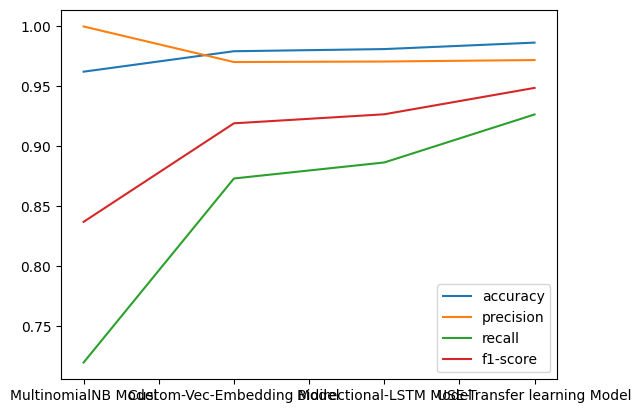

In [36]:
pd.DataFrame(total_results).plot()